In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import ascii, fits
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import Angle
from astropy.io.votable import parse_single_table
import popsims
import glob
import splat
%matplotlib inline

/users/caganze/research/splat


Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [2]:
columns_to_keep=['source_name', 'source_designation', 'ra', 'dec',  'simbad_type', 'sptype',
                'PS1_PSF_u', 'PS1_PSF_g', 'PS1_PSF_r', 'PS1_PSF_i', 'PS1_PSF_z', 'PS1_PSF_y',
                 'PS1_PSF_u_er', 'PS1_PSF_g_er', 'PS1_PSF_r_er', 'PS1_PSF_i_er', 'PS1_PSF_z_er', 'PS1_PSF_y_er',
                'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_y',
                'SDSS_u_er', 'SDSS_g_er', 'SDSS_r_er', 'SDSS_i_er', 'SDSS_y_er', 'Gaia_G','Gaia_G_er',
                 'Gaia_RP','Gaia_RP_er', 'Gaia_BP','Gaia_BP_er', 'parallax (mas)', 'parallax_er (mas)', 'catalog',
                'angSep']

In [3]:
#Simbad 
simbad=pd.read_csv('~/simbad_MLT_Sds_formatted.csv').reset_index(drop=True)
simbad_sdss=pd.read_csv('~/simbad_MLT_Sds_formatted_sdss_crossmatches.csv').reset_index(drop=True)
simbad_gaia=pd.read_csv('~/simbad_MLT_Sds_formatted_gaia_crossmatches.csv').reset_index(drop=True)
simbad_ps1=pd.read_csv('~/simbad_MLT_Sds_formatted_ps1_crossmatches.csv').reset_index(drop=True)

#Rename magnitudes before merging
for k in 'ugrizy':
    try:
        simbad_sdss=simbad_sdss.rename(columns={k+'mag': 'SDSS_'+k,
                                    'e_'+k+'mag': 'SDSS_'+k+'_er'})
        
        simbad_ps1=simbad_ps1.rename(columns={k+'mag_PS1': 'PS1_PSF_'+k,
                                    'e_'+k+'mag_PS1': 'PS1_PSF_'+k+'_er'})
    except KeyError:
        pass


In [4]:
#simbad.columns

In [5]:
Table.from_pandas(simbad[['identifier', 'ra', 'dec']]).write('/users/caganze/simbad_MLT_Sds_formatted_ra_dec.csv')

In [6]:
simbad_merged= simbad.merge(simbad_sdss, on='identifier', how='left').merge(simbad_gaia, how='left', on='identifier').merge(simbad_ps1, how='left', on='identifier')

In [7]:
simbad_merged=simbad_merged.reset_index(drop=True)

In [8]:
simbad_gaia.shape,  simbad_ps1.shape,  simbad_sdss.shape

((104, 116), (200, 40), (286, 59))

In [9]:
simbad_merged_coord=SkyCoord(ra=np.nanmedian(simbad_merged.ra_x.values, axis=1)*u.degree,\
                             dec=np.nanmedian(simbad_merged.dec_x.values, axis=1)*u.degree )

In [10]:
 simbad_merged["phot_g_mean_mag"].values.max()

nan

In [11]:
#manually write in simbad 
simbad_ref= pd.DataFrame(columns=columns_to_keep)
simbad_ref['source_name']=simbad_merged.identifier.values
simbad_ref['source_designation']=[splat.coordinateToDesignation(x) for x in simbad_merged_coord]
simbad_ref['simbad_type']= simbad_merged['spec. type_x'].values
simbad_ref['ra']=simbad_merged_coord.ra
simbad_ref['dec']=simbad_merged_coord.dec

simbad_ref['parallax (mas)']=simbad_merged.parallax.values
simbad_ref['parallax_er (mas)']=simbad_merged.parallax_error.values


#add magnitudes from ps1 and sdss
for k in 'ugrizy':
    try:
        simbad_ref['SDSS_'+k]= simbad_merged['SDSS_'+k].values
        simbad_ref['SDSS_'+k+'_er']=  simbad_merged['SDSS_'+k+'_er'].values

        simbad_ref['PS1_PSF_'+k]= simbad_merged['PS1_PSF_'+k].values
        simbad_ref['PS1_PSF_'+k+'_er']=  simbad_merged['PS1_PSF_'+k+'_er'].values
    except KeyError:
        pass
    
for k in ['G', 'RP', 'BP']:
    simbad_ref['Gaia_{}'.format(k)]=simbad_merged["phot_{}_mean_mag".format(k.lower())].values#,'Gaia_RP_er',]
    simbad_ref['Gaia_{}_er'.format(k)]= simbad_merged["phot_{}_mean_mag".format(k.lower())].values*(1/simbad_merged["phot_rp_mean_flux_over_error"]).values
    

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


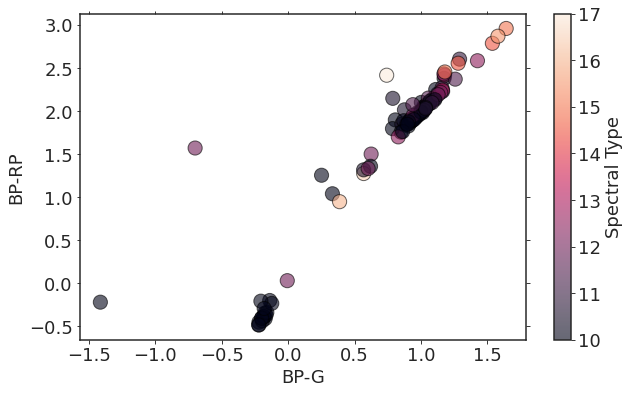

In [12]:
fig, ax=plt.subplots(figsize=(10, 6))
c=ax.scatter(simbad_ref['Gaia_{}'.format('BP')].values- simbad_ref['Gaia_{}'.format('G')].values,
           simbad_ref['Gaia_{}'.format('BP')].values- simbad_ref['Gaia_{}'.format('RP')].values, 
           s=200, c=simbad_ref['simbad_type'].apply(splat.typeToNum).values, \
           edgecolor='k', alpha=0.6)
plt.colorbar(c, label='Spectral Type')

ax.set(xlabel='BP-G', ylabel='BP-RP')

plt.savefig('../figures/sds_gaia_match.jpeg')

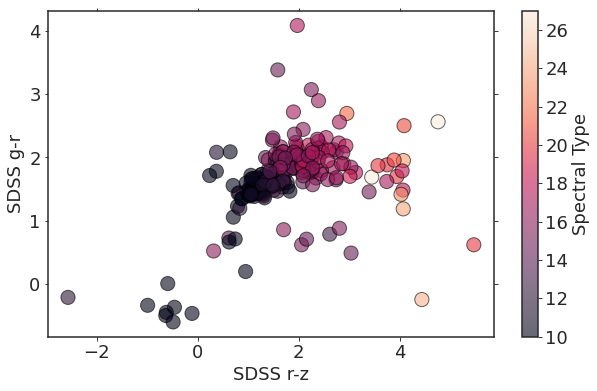

In [13]:
fig, ax=plt.subplots(figsize=(10, 6))
c=ax.scatter( simbad_ref['SDSS_r'].values- simbad_ref['SDSS_z'].values,
           simbad_ref['SDSS_g'].values- simbad_ref['SDSS_r'].values,
           s=200, c=simbad_ref['simbad_type'].apply(splat.typeToNum).values, \
           edgecolor='k', alpha=0.6)
plt.colorbar(c, label='Spectral Type')


ax.set(xlabel='SDSS r-z', ylabel='SDSS g-r')

plt.savefig('../figures/sds_sdss_match.jpeg')

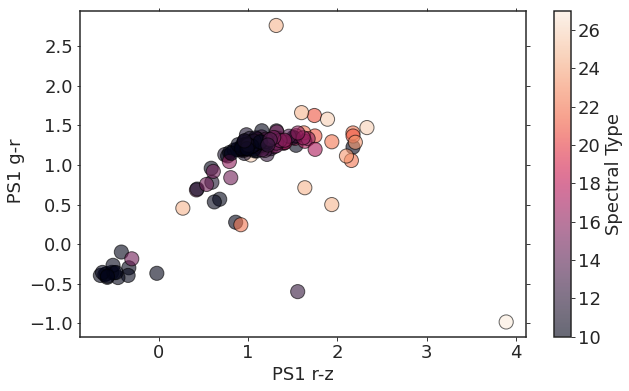

In [14]:
fig, ax=plt.subplots(figsize=(10, 6))
ax.scatter( simbad_ref['PS1_PSF_r'].values- simbad_ref['PS1_PSF_z'].values,
           simbad_ref['PS1_PSF_g'].values- simbad_ref['PS1_PSF_r'].values,
           s=200, c=simbad_ref['simbad_type'].apply(splat.typeToNum).values, \
           edgecolor='k', alpha=0.6)

plt.colorbar(c, label='Spectral Type')

ax.set(xlabel='PS1 r-z', ylabel=' PS1 g-r')

plt.savefig('../figures/sds_ps1_match.jpeg')

In [15]:
simbad_ps1['catalog']='simbad'

In [16]:
Table.from_pandas(simbad_ref).write('/users/caganze/simbad_subdwarfs_gaia_ps1_sdss.csv')
Table.from_pandas(simbad_ref).write('/volumes/LaCie/simbad_subdwarfs_gaia_ps1_sdss.csv')

In [17]:
#let's get the L dwarfs
#Lodieu
zhang_orig=   Table(fits.open('/volumes/LaCie/zhang/properties.fit')[1].data).to_pandas()
zhang_ps1=pd.read_csv('/Volumes/LaCie/zhang/Zhang_PS1_crossmatch.csv')
zhang_parallax= Table(fits.open('/volumes/LaCie/zhang/parallaxes.fit')[1].data).to_pandas()
zhang_gaia=Table(fits.open('/volumes/LaCie/zhang/zhang_gaia_match.fit')[1].data).to_pandas()

zhang_gaia['Name']=zhang_gaia.name.str.replace('\r', '').str.strip()
zhang_ps1['Name']=zhang_ps1.Name.str.replace('\r', '').str.strip()
zhang_orig['Name']=zhang_orig.Name.str.replace('\r', '').str.strip()
zhang_parallax['Name']=zhang_parallax.Name.str.replace('\r', '').str.strip()


In [18]:
zhang_parallax

,recno,SName,pmRA,e_pmRA,pmDE,e_pmDE,Dist,E_Dist,e_dist_lc,Vtan,E_Vtan,e_vtan_lc,Name
0,1,UL0118+03,14,12,-80,12,209,20,18,80,18,18,ULAS J011824.89+034130.4
1,2,UL0212+06,2,4,-429,5,139,13,12,282,27,25,ULAS J021258.08+064115.9
2,3,UL0238+05,186,18,-145,15,95,9,8,106,15,14,ULAS J023803.12+054526.1
3,4,UL0753+20,-36,1,-191,1,74,7,6,68,7,6,ULAS J075335.23+200622.4
4,5,UL0822+04,35,7,-154,5,92,9,8,69,8,7,ULAS J082206.61+044101.8
5,6,UL1114+07,-17,9,-306,6,211,20,18,306,31,29,ULAS J111429.54+072809.5
6,7,UL1231+01,-225,6,22,4,164,16,14,176,18,16,ULAS J123142.99+015045.4
7,8,UL1241-00,-61,9,-45,5,245,23,21,89,15,14,ULAS J124104.75-000531.4
8,9,UL1252+09,-299,7,6,6,117,11,10,166,17,15,ULAS J125226.62+092920.1
9,10,UL1307+15,-391,14,-124,13,86,8,8,168,18,17,ULAS J130710.22+151103.4


In [19]:
zhang_ps1.columns

Index(['Name', '_RA', '_DE', 'objID_PS1', 'RAJ2000_PS1', 'DEJ2000_PS1',
       'errHalfMaj_PS1', 'errHalfMin_PS1', 'errPosAng_PS1', 'f_objID_PS1',
       'Qual_PS1', 'Epoch_PS1', 'Ns_PS1', 'Nd_PS1', 'gmag_PS1', 'e_gmag_PS1',
       'gKmag_PS1', 'e_gKmag_PS1', 'gFlags_PS1', 'rmag_PS1', 'e_rmag_PS1',
       'rKmag_PS1', 'e_rKmag_PS1', 'rFlags_PS1', 'imag_PS1', 'e_imag_PS1',
       'iKmag_PS1', 'e_iKmag_PS1', 'iFlags_PS1', 'zmag_PS1', 'e_zmag_PS1',
       'zKmag_PS1', 'e_zKmag_PS1', 'zFlags_PS1', 'ymag_PS1', 'e_ymag_PS1',
       'yKmag_PS1', 'e_yKmag_PS1', 'yFlags_PS1', 'angDist_PS1'],
      dtype='object')

In [20]:
#Table.from_pandas(zhang_orig[['Name', '_RA', '_DE']]).write('/volumes/LaCie/zhang/properties_rad_dec.fit')

In [21]:
#Rename magnitudes before merging
for k in 'ugrizy':
    try:
        
        zhang_orig=zhang_orig.rename(columns={k+'mag': 'SDSS_'+k,
                                    'e_'+k+'mag': 'SDSS_'+k+'_er'})
        #it has _ps1 except for G
        zhang_ps1=zhang_ps1.rename(columns={k+'mag_PS1': 'PS1_PSF_'+k,
                                    'e_'+k+'mag_PS1': 'PS1_PSF_'+k+'_er'})
    except KeyError:
        print (k)

In [22]:
zhang_merged= zhang_orig.merge(zhang_gaia, on='Name', how='left').merge(zhang_ps1, how='left', on='Name').merge(zhang_parallax, on='Name', how='left' )


In [23]:
zhang_coord=SkyCoord(ra=zhang_orig._RA*u.degree,\
                             dec=zhang_orig._DE*u.degree )

In [24]:
zhang_merged.columns

Index(['recno_x', 'Name', 'n_Name', 'SpType', 'n_SpType', 'SDSS_i',
       'SDSS_i_er', 'SDSS_z', 'SDSS_z_er', 'Ymag',
       ...
       'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Dist', 'E_Dist', 'e_dist_lc',
       'Vtan', 'E_Vtan', 'e_vtan_lc'],
      dtype='object', length=172)

In [25]:
zhang_ps1.columns
#G AND R ARE FROM PS1 THE REST ARE SDSS

Index(['Name', '_RA', '_DE', 'objID_PS1', 'RAJ2000_PS1', 'DEJ2000_PS1',
       'errHalfMaj_PS1', 'errHalfMin_PS1', 'errPosAng_PS1', 'f_objID_PS1',
       'Qual_PS1', 'Epoch_PS1', 'Ns_PS1', 'Nd_PS1', 'PS1_PSF_g',
       'PS1_PSF_g_er', 'gKmag_PS1', 'e_gKmag_PS1', 'gFlags_PS1', 'PS1_PSF_r',
       'PS1_PSF_r_er', 'rKmag_PS1', 'e_rKmag_PS1', 'rFlags_PS1', 'PS1_PSF_i',
       'PS1_PSF_i_er', 'iKmag_PS1', 'e_iKmag_PS1', 'iFlags_PS1', 'PS1_PSF_z',
       'PS1_PSF_z_er', 'zKmag_PS1', 'e_zKmag_PS1', 'zFlags_PS1', 'PS1_PSF_y',
       'PS1_PSF_y_er', 'yKmag_PS1', 'e_yKmag_PS1', 'yFlags_PS1',
       'angDist_PS1'],
      dtype='object')

In [26]:
#manually write in simbad 
zhang_ref= pd.DataFrame(columns=columns_to_keep)
zhang_ref['source_name']=zhang_merged.Name.values
zhang_ref['source_designation']=[splat.coordinateToDesignation(x) for x in zhang_coord]
zhang_ref['sptype']= zhang_merged.SpType.values
zhang_ref['ra']=zhang_coord.ra
zhang_ref['dec']=zhang_coord.dec

zhang_ref['parallax (mas)']=np.nanmedian(1000/(np.random.normal(zhang_merged.Dist.values, zhang_merged.E_Dist, (1000, len(zhang_merged)))), axis=0)
zhang_ref['parallax_er (mas)']=np.nanstd(1000/(np.random.normal(zhang_merged.Dist.values, zhang_merged.E_Dist, (1000, len(zhang_merged)))), axis=0)

#add magnitudes from ps1 and sdss
for k in 'ugrizy':
    try:
        zhang_ref['SDSS_'+k]= zhang_merged['SDSS_'+k].values
        zhang_ref['SDSS_'+k+'_er']=   zhang_merged['SDSS_'+k+'_er'].values

        zhang_ref['PS1_PSF_'+k]= zhang_merged['PS1_PSF_'+k].values
        zhang_ref['PS1_PSF_'+k+'_er']=   zhang_merged['PS1_PSF_'+k+'_er'].values
    except KeyError:
        print (k)
        pass
    
for k in ['G', 'RP', 'BP']:
    zhang_ref['Gaia_{}'.format(k)]=zhang_merged["phot_{}_mean_mag".format(k.lower())].values#,'Gaia_RP_er',]
    zhang_ref['Gaia_{}_er'.format(k)]= zhang_merged["phot_{}_mean_mag".format(k.lower())].values*(1/zhang_merged["phot_rp_mean_flux_over_error"]).values
    

u
g
r
y


In [27]:
zhang_ref['catalog']='zhang'

In [28]:
zhang_ref

,source_name,source_designation,ra,dec,simbad_type,sptype,PS1_PSF_u,PS1_PSF_g,PS1_PSF_r,PS1_PSF_i,...,Gaia_RP,Gaia_RP_er,Gaia_BP,Gaia_BP_er,parallax (mas),parallax_er (mas),catalog,angSep,SDSS_z,SDSS_z_er
0,SDSS J010448.47+153501.9,J01044847+1535019,16.20196,15.58386,NaN,usdL1.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,zhang,NaN,19.29,0.06
1,SSSPM J10130734-1356204,J10130734-1356204,153.28058,-13.93900,NaN,usdL0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,zhang,NaN,16.09,0.01
2,SDSS J125637.13-022452.4,J12563714-0224523,194.15475,-2.41453,NaN,usdL3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,zhang,NaN,17.71,0.02
3,ULAS J135058.85+081506.8,J13505885+0815068,207.74521,8.25189,NaN,usdL3,NaN,NaN,NaN,21.2557,...,NaN,NaN,NaN,NaN,NaN,NaN,zhang,NaN,19.47,0.06
4,2MASS J16262034+3925190,J16262013+3925195,246.58387,39.42208,NaN,usdL4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,zhang,NaN,16.16,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,LSR J182611.3+301419.1,J18261130+3014191,276.54708,30.23864,NaN,sdL0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,zhang,NaN,0.00,0.00
62,ULAS J223440.80+001002.6,J22344080+0010026,338.67000,0.16739,NaN,sdL1,NaN,NaN,NaN,21.8284,...,NaN,NaN,NaN,NaN,6.894776,0.703382,zhang,NaN,20.16,0.12
63,ULAS J225902.14+115602.1,J22590214+1156021,344.75892,11.93392,NaN,sdL0,NaN,NaN,NaN,21.1627,...,NaN,NaN,NaN,NaN,8.008901,0.780752,zhang,NaN,19.23,0.11
64,ULAS J230256.53+121310.2,J23025653+1213102,345.73554,12.21950,NaN,sdL0,NaN,NaN,NaN,21.2587,...,NaN,NaN,NaN,NaN,6.557439,0.668330,zhang,NaN,19.46,0.08


In [29]:
Table.from_pandas(zhang_ref).write('/users/caganze/zhang_subdwarfs_gaia_ps1_sdss.csv')
Table.from_pandas(zhang_ref).write('/volumes/LaCie/zhang_subdwarfs_gaia_ps1_sdss.csv')

In [30]:
zhang_ref.applymap(str).to_latex('../data/zhang_croosmatches.tex', na_rep=' ', index=False)

In [31]:
#Hejazi dwarfgs
df=ascii.read('/volumes/LaCie/hejazi/astrometry.txt').to_pandas()
df_class=ascii.read('/Volumes/LaCie/hejazi/classifications.txt').to_pandas()
cross_matches=pd.read_csv('/volumes/LaCie/hejazi/gaia_crossmatch.txt')

all_merged=df.merge(df_class)
hejazi_df=cross_matches.merge(df_class, on='ID', how='left').merge(df, on='ID', how='left')
hejazi_df['num_type']=hejazi_df.SpType.apply(splat.typeToNum)
sd_bool=hejazi_df.SpType.str.contains('sd')

In [32]:
Table.from_pandas(hejazi_df[sd_bool][['ra', 'dec', 'DESIGNATION']]).write('/volumes/LaCie/hejazi/hejazi_ra_dec.csv')



In [33]:
df

,ID,RAdeg,DEdeg,pmRA,pmDE,plx,Gaia
0,PM_I00012+0659,0.31397,6.99282,-0.4363,-0.0834,0.04278,DR3
1,PM_I00031+0616,0.78061,6.27530,0.2389,-0.5128,0.03430,DR3
2,PM_I00051+4547,1.30092,45.78589,0.8707,-0.1514,0.08693,DR3
3,PM_I00077+6022,1.93035,60.38166,0.3216,-0.0031,0.06500,DR3
4,PM_I00078+6736,1.96105,67.60664,-0.0559,-0.0911,0.03965,DR3
...,...,...,...,...,...,...,...
3740,PM_I23580+7836,359.51736,78.60781,0.4746,-0.1370,0.03904,DR3
3741,PM_I23580-1723,359.52447,-17.39461,0.3821,-0.0784,0.02794,DR3
3742,PM_I23587+4643,359.68543,46.72915,0.6528,0.0134,0.05841,DR2
3743,PM_I23595+4255,359.89730,42.92756,0.4372,-0.1908,0.02796,DR3


In [34]:
#compare subdwarfs to dwarfs
df=pd.read_pickle('/Volumes/LaCie/Best2018_masked.csv.gz')

In [35]:
simbad_ref['numspt']=simbad_ref.simbad_type.apply(splat.typeToNum)
zhang_ref['numspt']=zhang_ref.sptype.apply(splat.typeToNum)

In [36]:
#zhang_ref

In [37]:
abs_mags_tables=pd.concat([simbad_ref, zhang_ref])

In [38]:
def get_abs_mags(m, merr, p, perr):
    ds= 1000/np.random.normal(p, perr, 1000)
    ms= np.random.normal(m, merr, 1000)
    res= ms-5*np.log10(ds/10.0)
    return np.nanmedian(res), np.nanstd(res)

#first compute SDSS_ABS_MAGS
for k in 'ugrizy':
    for sur in ['SDSS', 'PS1_PSF']:
        m=abs_mags_tables['{}_{}'.format(sur, k)].values.astype(float)
        merr=abs_mags_tables['{}_{}_er'.format(sur, k)].values.astype(float)
        p=abs_mags_tables['parallax (mas)'].values.astype(float)
        perr=abs_mags_tables[ 'parallax_er (mas)'].values.astype(float)
        vs=[get_abs_mags(mx, merrx, px, perrx) for mx, merrx, px, perrx in zip(m, merr, p, perr)]
        absm=np.vstack(vs)[:,0]
        absmerr=np.vstack(vs)[:,1]

        abs_mags_tables['abs_{}_{}'.format(sur, k)]= absm
        abs_mags_tables['abs_{}_{}_er'.format(sur, k)]= absmerr

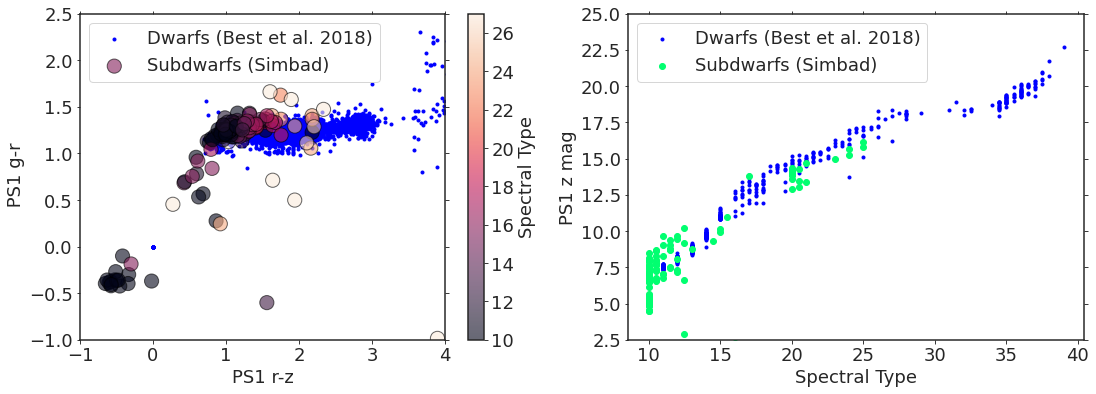

In [40]:
fig, (ax, ax1)=plt.subplots(figsize=(12*1.5, 4*1.5), ncols=2)
ax.scatter(df.PS1rmag-df.PS1zmag, df.PS1gmag- df.PS1rmag, c='b', marker='.', label='Dwarfs (Best et al. 2018)')
ax.scatter( abs_mags_tables['PS1_PSF_r'].values- abs_mags_tables['PS1_PSF_z'].values,
           abs_mags_tables['PS1_PSF_g'].values- abs_mags_tables['PS1_PSF_r'].values,
           s=200, c=abs_mags_tables.numspt.values, \
           edgecolor='k', alpha=0.6, label='Subdwarfs (Simbad)', vmin=10, vmax=16)

plt.colorbar(c, ax=ax, label='Spectral Type')
ax.legend()

ax.set(xlabel='PS1 r-z', ylabel=' PS1 g-r', ylim=[-1, 2.5], xlim=[-1, 4] )


ax1.scatter(df.SpT.apply(splat.typeToNum), df['absolute_PS1zmag'],  c='b', marker='.', \
            label='Dwarfs (Best et al. 2018)')
ax1.scatter(abs_mags_tables.numspt.values,
            abs_mags_tables['abs_PS1_PSF_z'].values    , color='#01FF70',  label='Subdwarfs (Simbad)'    )

#plt.colorbar(c, ax=ax1, label='Spectral Type')
ax1.legend()

ax1.set(xlabel='Spectral Type', ylabel='PS1 z mag',  ylim=[2.5, 25])



plt.savefig('../figures/PS1_colors.jpeg')